# An overview of MetaPhlan and HuMANN results



## Hostile contamination

First, let's check we have the needed files:

In [175]:
# import libraries 
import pandas as pd
import seaborn as sns
import re
 
# Use remote files
metadata_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/biobakery-2024/main/datasets/lokmer.csv'
 


## Metadata

Let's import the metadata and try to format in a more useful way

In [176]:
metadataFullDf = pd.read_csv(metadata_url)
metadataFullDf.set_index('run_accession', inplace=True)
cols = ['sample_title', 'sample_description']

metadataDf = metadataFullDf[cols]

# Extracting the columns from the sample_description column
# using regular expressions
extracted_data = metadataDf['sample_description'].str.extract(r'Faecal metagenome of a (\d+) old (female|male) from ([^,]+), (\w+)')
extracted_data.columns = ['age', 'sex', 'location', 'country']

# Concatenating the extracted columns back to the original DataFrame
metadataDf = pd.concat([metadataDf, extracted_data], axis=1)
metadataDf.drop('sample_description', axis=1, inplace=True)

# We extracted pieces of strings, but age is numbers
metadataDf['age'] = pd.to_numeric(metadataDf['age'])
# Display the DataFrame
metadataDf.head()
 

,sample_title,age,sex,location,country
run_accession,,,,,
ERR2619707,Cam2013_BAB01,61,male,Bandevouri,Cameroon
ERR2619708,Cam2013_BAB04,41,male,Bidou,Cameroon
ERR2619709,Cam2013_BAB06,49,female,Bidou,Cameroon
ERR2619710,Cam2013_BAB07,57,male,Bidou,Cameroon
ERR2619711,Cam2013_BAB08,53,female,Bidou,Cameroon


It's always a good idea to start exploring the metadata, checking for missing values etc. In our case we didn't have any, but we can now see how the dataset looks like

In [177]:
# How many % females?
female_ratio = (metadataDf['sex'] == 'female').mean() * 100
female_ratio


43.859649122807014

In [178]:
# How many cities? Display country, percentage in descending order
city_counts = metadataDf['location'].value_counts(normalize=True) * 100
city_counts

location
Ebodié          33.333333
Bandevouri      17.543860
Afan Essokié    15.789474
Akak            14.035088
Bidou           10.526316
Makouvé          5.263158
Ndtoua           3.508772
Name: proportion, dtype: float64

### Plotting age distribution

Let's make our first plot using the "age" column

[Text(0.5, 1.0, 'Age Distribution'),
 Text(0.5, 0, 'Age'),
 Text(0, 0.5, 'Frequency')]

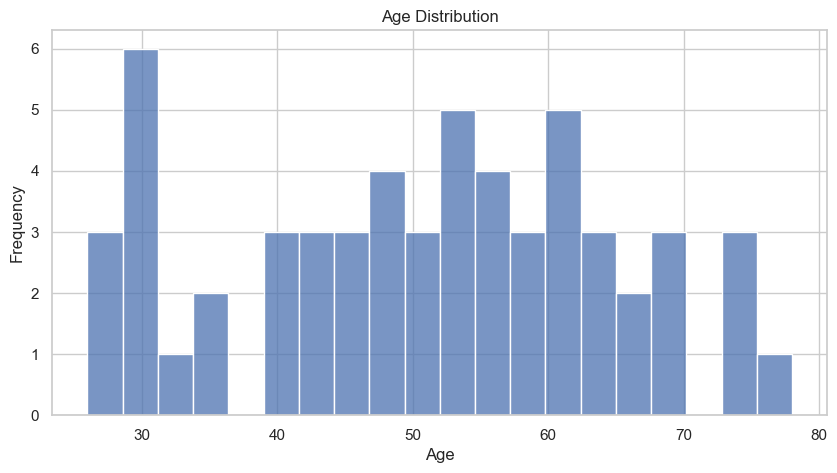

In [179]:

# First, let's sort age
metadataDf = metadataDf.sort_values(by='age')
 

# Plotting the histogram
 
sns.histplot(metadataDf['age'], kde=False, bins=20).set(
    title='Age Distribution', xlabel='Age', ylabel='Frequency')
 


In [180]:
# Can we now arbitrarily bin the samples in three groups after seeing the plot?
young_adults = (metadataDf['age'] < 40).sum()

senior = (metadataDf['age'] > 60).sum()

other = len(metadataDf) - young_adults - senior
young_adults, senior, other

(12, 17, 28)

## Import the metaphlan table

In [181]:
mpa_url = 'https://raw.githubusercontent.com/quadram-institute-bioscience/biobakery-2024/main/datasets/lokmer_metaphlan.tsv.gz'
mpaDf = pd.read_csv(mpa_url, compression='gzip', sep='\t', header=1)
mpaDf.set_index('clade_name', inplace=True)
mpaDf.head()

,ERR2619707,ERR2619708,ERR2619709,ERR2619710,ERR2619711,ERR2619712,ERR2619713,ERR2619714,ERR2619715,ERR2619716,...,ERR2619754,ERR2619755,ERR2619756,ERR2619757,ERR2619758,ERR2619759,ERR2619760,ERR2619761,ERR2619762,ERR2619763
clade_name,,,,,,,,,,,,,,,,,,,,,
UNCLASSIFIED,38.481370,34.380640,21.611820,25.752700,27.260530,21.946400,32.934470,16.012430,23.909180,24.084470,...,21.910020,33.182930,33.482040,26.430190,31.012000,20.879670,18.338990,23.488640,25.466750,44.321980
k__Bacteria,61.493694,65.522322,78.351099,74.247297,72.676965,78.053603,67.065527,83.978157,75.899631,75.894056,...,77.656538,66.732659,66.517962,73.569805,68.987997,79.120334,81.156355,76.431814,74.533254,55.678021
k__Archaea,0.024940,0.097038,0.037078,0.000000,0.051427,0.000000,0.000000,0.009415,0.191186,0.020543,...,0.433446,0.027241,0.000000,0.000000,0.000000,0.000000,0.504657,0.077078,0.000000,0.000000
k__Bacteria|p__Firmicutes,39.921779,19.063769,36.513996,33.345835,41.810669,23.407284,0.863958,41.376990,17.609538,31.591460,...,32.662862,25.145882,12.517982,20.454870,11.506777,5.703286,25.569859,31.798551,29.166621,13.613404
k__Bacteria|p__Bacteroidetes,19.615985,35.963950,15.801802,34.109995,15.755857,32.392495,0.001274,31.638438,25.424658,29.919314,...,28.922242,11.421877,49.735201,44.033875,38.770868,64.962604,39.369901,18.780548,42.871431,10.132971


Now we have two tables. Let's check the metadata fits the abundance table.

In [182]:
# the columns of mpaDf are the samples, that are the same as the index of metadataDf. 
# (order does not matter)
set(metadataDf.index) == set(mpaDf.columns)

True

Now, let's compare the average and standard deviation of the
percentage of UNCLASSIFIED in each category: young_adults, senior, other

In [183]:
#Now, let's compare the average and standard deviation of the
#percentage of UNCLASSIFIED in each category: young_adults, senior, other

# First, we need to extract the UNCLASSIFIED row
unclassified = mpaDf.loc['UNCLASSIFIED']

# Now, we can calculate the average and standard deviation
# of the percentage of UNCLASSIFIED in each category. UNCLASSIFIED is already a percentage

young_adults_unclassified = unclassified[metadataDf.loc[unclassified.index, 'age'] < 40]
senior_unclassified = unclassified[metadataDf.loc[unclassified.index, 'age'] > 60]
other_unclassified = unclassified[metadataDf.loc[unclassified.index, 'age'].between(40, 60)]

print(f"<40:\t{young_adults_unclassified.mean()}\t± {young_adults_unclassified.std()}")
print(f"40-60:\t{other_unclassified.mean()}\t± {other_unclassified.std()}")
print(f">60:\t{senior_unclassified.mean()}\t± {senior_unclassified.std()}")


<40:	30.740891666666666	± 9.92918668956035
40-60:	27.947001071428577	± 7.563895038003625
>60:	28.673829411764704	± 6.58709526630334


If you observe the clade names, you will notice that they are provided at different taxonomic levels.
Let's check the sum of each column: we dont expect it to be 100.

In [184]:
# Print the sum of all columns
mpaDf.sum().sort_values(ascending=False).to_frame().set_axis(['sum'], axis=1)

,sum
ERR2619733,692.546102
ERR2619714,686.285084
ERR2619760,669.561620
ERR2619732,657.999125
ERR2619759,653.665188
ERR2619712,644.170519
ERR2619736,643.113425
ERR2619734,642.322681
ERR2619754,641.814732
ERR2619729,638.919432


What if we want an overview at the genus level?

In [188]:
def string_to_rank(s):
    """
    Convert a clade_name like k__Bacteria|p__Firmicutes|c__CFGB76578|o__OFGB76578|f__FGB76578|g__GGB79648
    to a rank, in this case "genus"
    """
    return s.split('|')[-1].split('__')[0].lower()

def last_rank(s):
    return s.split('|')[-1].split('__')[1] if '__' in s else s

# Convert the index to ranks
ranks = mpaDf.index.map(string_to_rank)
mpaSpeciesDf = mpaDf.copy()

# Keep only rows with rank "s" or "unclassified"
mpaSpeciesDf = mpaSpeciesDf[ranks.isin(['s', 'unclassified'])]

mpaSpeciesDf.index = mpaSpeciesDf.index.map(last_rank)
# Now the sum should be 100%: all genera detected plus unclassified
mpaSpeciesDf.sum() 

,ERR2619707,ERR2619708,ERR2619709,ERR2619710,ERR2619711,ERR2619712,ERR2619713,ERR2619714,ERR2619715,ERR2619716,...,ERR2619754,ERR2619755,ERR2619756,ERR2619757,ERR2619758,ERR2619759,ERR2619760,ERR2619761,ERR2619762,ERR2619763
clade_name,,,,,,,,,,,,,,,,,,,,,
UNCLASSIFIED,38.481370,34.380640,21.611820,25.752700,27.260530,21.946400,32.93447,16.012430,23.909180,24.084470,...,21.910020,33.18293,33.482040,26.430190,31.012000,20.879670,18.338990,23.488640,25.466750,44.321980
GGB4884_SGB6823,14.380934,0.023721,0.047707,0.034325,0.158121,0.354348,0.00000,0.222416,0.005060,0.223700,...,0.008910,0.00000,0.000000,0.000000,0.000000,0.000000,0.042447,0.056718,0.000000,0.000000
GGB1627_SGB2227,10.325238,0.000000,0.143435,0.000000,0.000000,0.000000,0.00000,0.000655,0.268875,1.062043,...,0.840646,0.00000,0.000000,0.000000,0.000000,0.000000,0.000653,0.000559,0.000000,0.000000
Phascolarctobacterium_succinatutens,1.667782,1.240121,0.212017,0.000000,0.000000,0.740471,0.00000,0.999637,0.847789,0.682815,...,0.390466,0.00000,1.244232,1.840069,0.737468,0.182934,0.434020,1.614589,0.000969,0.000056
Prevotella_pectinovora,1.535536,0.000000,0.181680,0.000000,0.000000,0.000000,0.00000,0.376625,1.057746,0.255714,...,0.000000,0.00000,0.000000,1.750579,0.000000,0.676811,0.533687,0.145563,0.000000,0.000000


What are the top 10 species in this dataset?


In [190]:
# Print the top 10 species (clade_name) in the mpaSpeciesDf

total_abundance = mpaSpeciesDf.sum(axis=1)

# Sort the species by their total abundance in descending order
sorted_abundance = total_abundance.sort_values(ascending=False)

# Select the top 10 species
top_10_species = sorted_abundance.head(10)

# Display the top 10 species
print(top_10_species)



clade_name
UNCLASSIFIED                    1638.861830
GGB2734_SGB3677                  294.457533
Prevotella_copri_clade_A         183.185866
Escherichia_coli                 130.597965
Prevotella_copri_clade_G         125.107506
Faecalibacterium_prausnitzii     114.561587
Prevotella_copri_clade_C         114.440994
GGB1627_SGB2230                   75.952144
Prevotella_copri_clade_D          68.135776
Treponema_succinifaciens          66.506303
dtype: float64


[Text(0.5, 1.0, 'Top 10 Species'),
 Text(0.5, 22.249999999999993, 'Sample'),
 Text(92.10937499999999, 0.5, 'Species')]

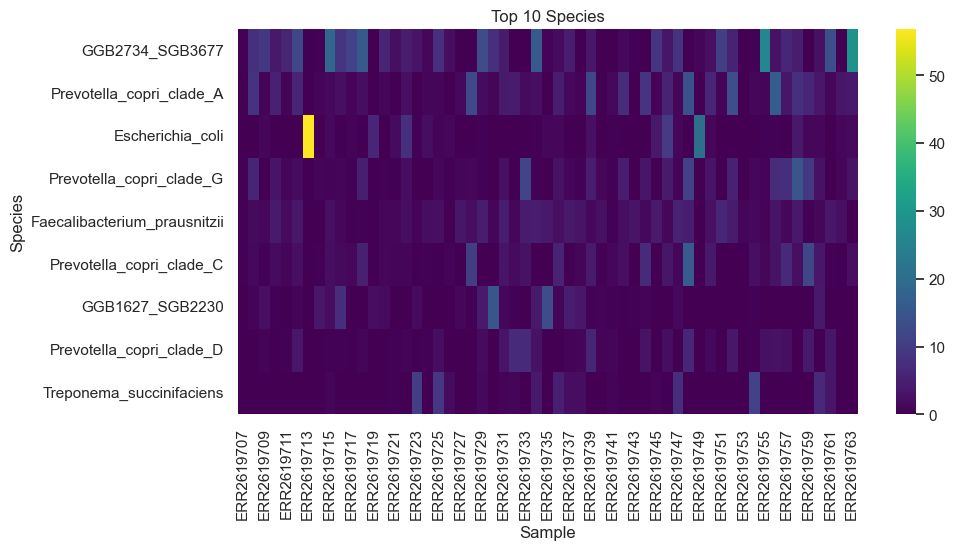

In [194]:

topSpeciesDf = mpaSpeciesDf.loc[top_10_species.index]

# Drop "unclassified" row
topSpeciesDf = topSpeciesDf.drop('UNCLASSIFIED') 

# Heatmap
sns.heatmap(topSpeciesDf, cmap='viridis').set(
    title='Top 10 Species', xlabel='Sample', ylabel='Species')

Apparently a sample is quite rich in *E. coli*...